In [1]:
# Initializing Model and First Analysis Run
import os
nLoadCases = 150
os.environ["MAX_LOADCASE"] = str(nLoadCases)

from scipy import sparse as sp
from Examples.RDSO45mTruss.Structure3D import Structure3D
from Models import DOFClass
import time
startTime = time.time()

print("**** Defining the structure ****")
structure = Structure3D()
print(f"Execution Time = {time.time() - startTime:.2f} secs")

print("**** Loading ImbalancedActionVector from File ****")
ImbalancedActionVectorFromFile = sp.lil_array(sp.load_npz(f'DataExchange/.ImbalancedActionVector{nLoadCases}.npz'))
DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()
print(f"Execution Time = {time.time() - startTime:.2f} secs")

print("**** Analysing file ****")
DOFClass.analyse()
print(f"Execution Time = {time.time() - startTime:.2f} secs")


**** Defining the structure ****
Execution Time = 1.62 secs
**** Loading ImbalancedActionVector from File ****
Execution Time = 1.64 secs
**** Analysing file ****


c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Execution Time = 3.14 secs


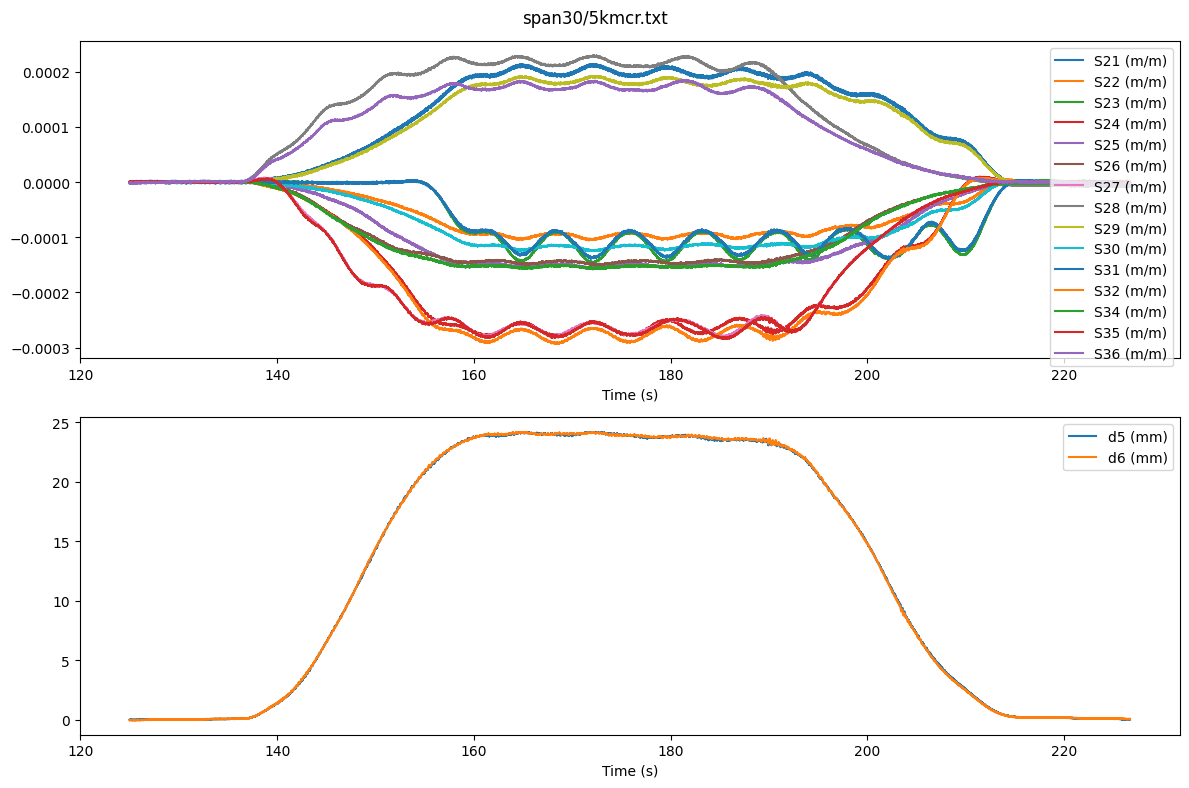

In [2]:
# Live Load Results from Sensor Data
import pandas as pd
import matplotlib.pyplot as plt

def getLLDataFromFile(_FILENAME, _filterStrainRegex='', _filterDispRegex='', _startTime=0, _endTime=100000, _filterStartTime=0, _filterEndTime=10) -> pd.DataFrame:
  _dfSensorRaw = pd.read_csv(_FILENAME, sep='\t')
  _dfSensorRaw["Time"] = _dfSensorRaw["Time"].apply(pd.to_timedelta)
  _dfSensorRaw["Time"] = (_dfSensorRaw["Time"] - _dfSensorRaw["Time"].min()).dt.total_seconds()
  _dfSensorRaw = _dfSensorRaw.set_index("Time")
  _dfSensorRaw.index.name = "Time (s)"
  _dfSensorRaw = _dfSensorRaw.filter(regex='^[Sd]')
  if _filterStrainRegex != '':
    _dfSensorRaw = _dfSensorRaw.filter(regex=_filterStrainRegex)
  if _filterDispRegex != '':
    _dfSensorRaw = _dfSensorRaw.filter(regex=_filterDispRegex)
  
  # removing the constant value using filterStartTime and filterEndTime
  _dfSensorRaw = _dfSensorRaw - _dfSensorRaw.iloc[(_dfSensorRaw.index>=_filterStartTime) & (_dfSensorRaw.index<=_filterEndTime)].mean()

  # Trimming outside startTime and endTime
  _dfSensorRaw = _dfSensorRaw[(_dfSensorRaw.index>=_startTime) & (_dfSensorRaw.index<=_endTime)]
  
  # Setting up for plotting
  _fig, (_ax1, _ax2) = plt.subplots(2,1,figsize=(12,8), layout='tight')
  _fig.suptitle(_FILENAME)
  
  # Extracing results of strains from sensors
  _dfSensorRaw.filter(regex='^S').plot(ax=_ax1)
  _ax1.legend(loc="upper right")

  # Extracing results of displacements from sensors
  _dfSensorRaw.filter(regex='^d').plot(ax=_ax2)
  _ax2.legend(loc="upper right")

  return _dfSensorRaw

dfSensorRaw = getLLDataFromFile('span30/5kmcr.txt', _filterStrainRegex=r'^(?!(S33|S37|S38|S39|S40))', _filterDispRegex=r'^(?!(d7))', _startTime=125, _endTime=1000, _filterStartTime=125, _filterEndTime=135)

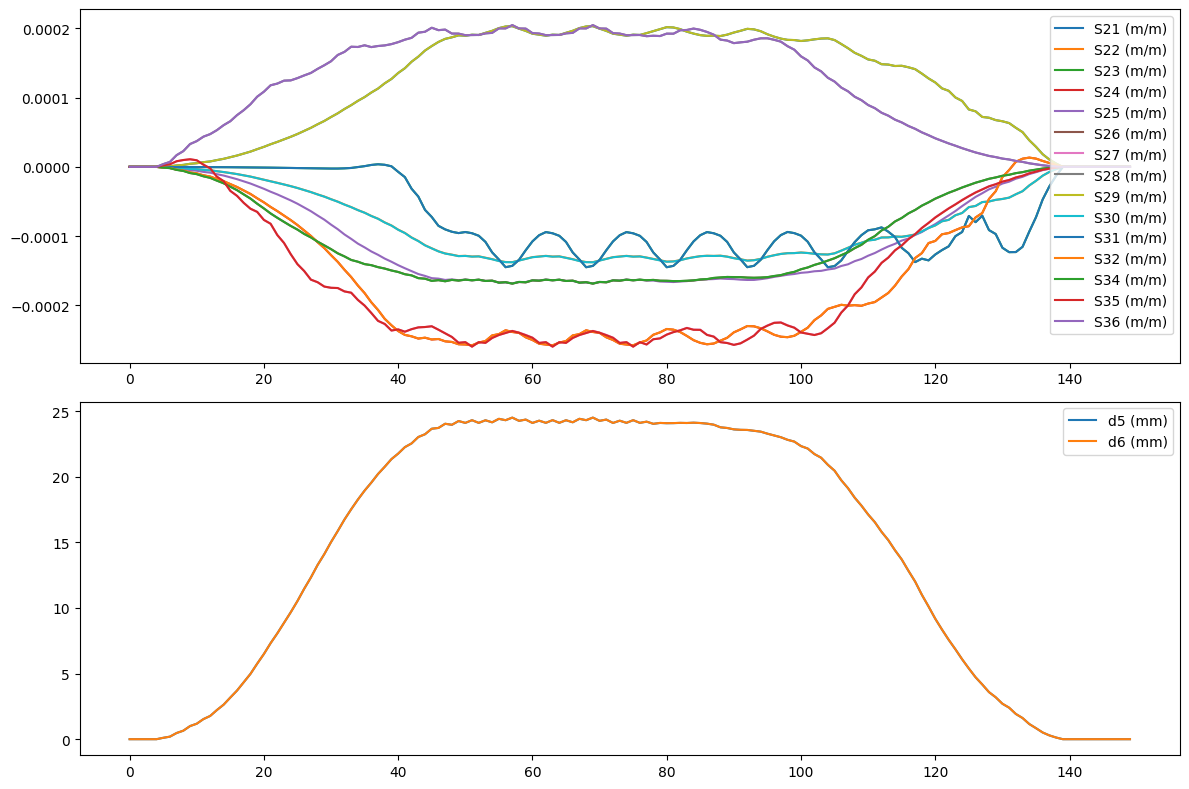

In [3]:
# Live Load Results from Numerical Model
from typing import Union
from Models import FixedBeam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def getLLResultsFromNumericalModel(_elements:list[Union[DOFClass,FixedBeam]], _columns, _shouldPlot=False):
  _elementResponses = []
  _loadCases = list(reversed(range(nLoadCases)))
  for __element in _elements:
    if type(__element) is DOFClass:
      __elementResponse = -__element.displacement(_loadCases).flatten()
      _elementResponses.append(__elementResponse*1000)
    elif type(__element) is FixedBeam:
      __elementResponse = -__element.getAxialStrainForLoadCases(_loadCases).flatten()
      _elementResponses.append(__elementResponse)
  _dfNumericalRaw = pd.DataFrame(np.array(_elementResponses).T, columns=_columns)

  if _shouldPlot:
    # Setting up for plotting
    _fig, (_ax1, _ax2) = plt.subplots(2,1,figsize=(12,8), layout='tight')
    
    # Extracing results of strains from sensors
    _dfNumericalRaw.iloc[:,[type(__element) is FixedBeam for __element in _elements]].plot(ax=_ax1)
    _ax1.legend(loc="upper right")

    # Extracing results of displacements from sensors
    _dfNumericalRaw.iloc[:,[type(__element) is DOFClass for __element in _elements]].plot(ax=_ax2)
    _ax2.legend(loc="upper right")
  
  return _dfNumericalRaw

resultElements:list[Union[DOFClass,FixedBeam]] = [
  structure.truss1.node_by_name("L4").DOF[2], #d5
  structure.truss2.node_by_name("L4").DOF[2], #d6
  # structure.truss2.node_by_name("L4").DOF[1], #d7
  structure.truss1.diagonalBeams[0].childBeams[0], #S21
  structure.truss1.bottomChordBeams[0].childBeams[0], #S22
  structure.truss1.verticalBeams[0].childBeams[0], #S23
  structure.truss1.diagonalBeams[1].childBeams[0], #S24
  structure.truss1.bottomChordBeams[1].childBeams[1], #S25
  structure.truss1.bottomChordBeams[2].childBeams[0], #S26
  structure.truss1.diagonalBeams[-2].childBeams[0], #S27
  structure.truss1.diagonalBeams[-1].childBeams[0], #S28
  structure.truss2.diagonalBeams[0].childBeams[0], #S29
  structure.truss2.bottomChordBeams[0].childBeams[0], #S30
  structure.truss2.verticalBeams[0].childBeams[0], #S31
  structure.truss2.diagonalBeams[1].childBeams[0], #S32
  # structure.truss2.bottomChordBeams[1].childBeams[1], #S33
  structure.truss2.bottomChordBeams[2].childBeams[0], #S34
  structure.truss2.diagonalBeams[-2].childBeams[0], #S35
  structure.truss2.diagonalBeams[-1].childBeams[0], #S36
]

dfNumericalRaw = getLLResultsFromNumericalModel(resultElements, dfSensorRaw.columns, _shouldPlot=True)

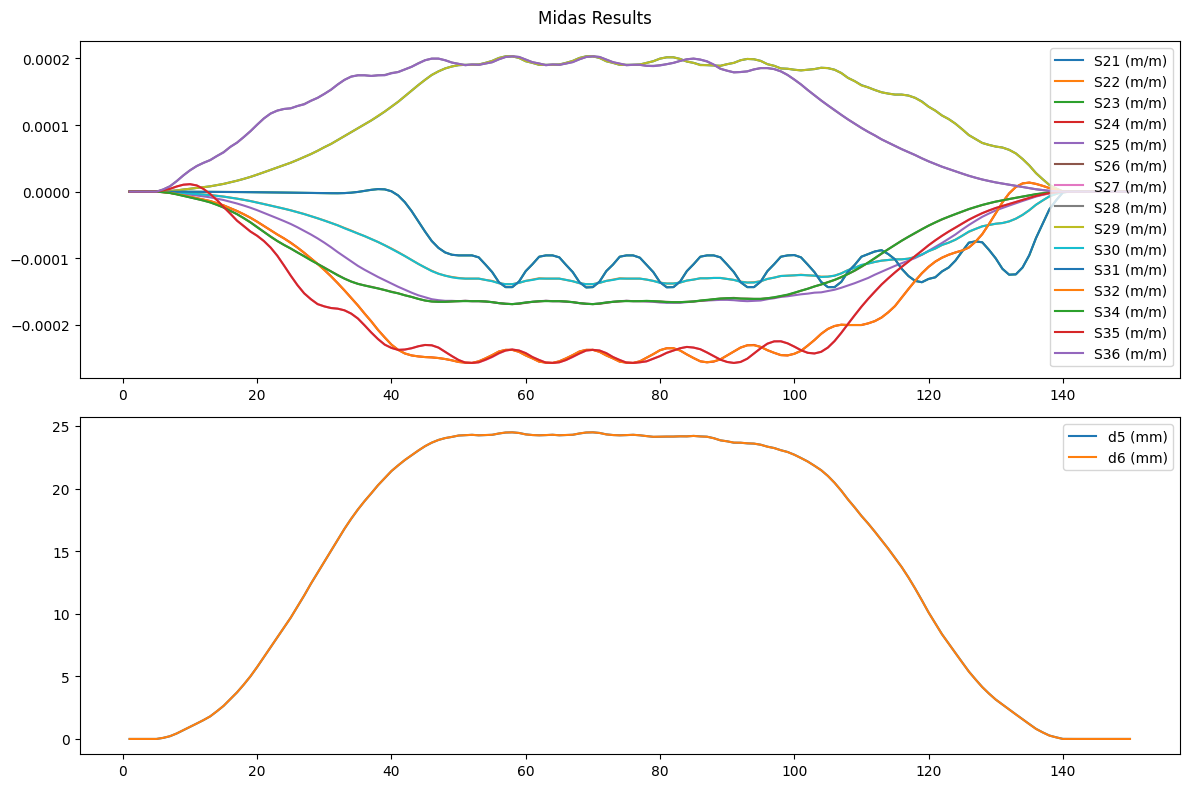

In [2]:
# Live Load Results from Midas Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def getLLDataFromMidasOutput(_FILENAME_STRESS, _FILENAME_DISP, _stressColumnChange:dict[int, str], _dispColumnChange:dict[int, str], _filterStrainRegex="", _filterDispRegex="", _shouldPlot=True) -> pd.DataFrame:
  # Extracting Starin Results
  _dfMidasStrain = pd.read_excel(_FILENAME_STRESS, skiprows=1, usecols='C, D, K')
  _dfMidasStrain['Load'] = np.array(_dfMidasStrain['Load'].str.extractall(r'(\d+)')[0].astype(int))
  E = 200e6/9.81
  _dfMidasStrain['Strain (m/m)'] = -_dfMidasStrain.iloc[:,2]/E
  _dfMidasStrain = _dfMidasStrain \
      .pivot(index='Load', columns='Elem', values='Strain (m/m)') \
      .sort_values(by='Load')
  _dfMidasStrain.columns = _dfMidasStrain.columns.to_list()
  _dfMidasStrain.index = reversed(_dfMidasStrain.index.to_list())
  _dfMidasStrain = _dfMidasStrain[list(_stressColumnChange.keys())].sort_index()
  _dfMidasStrain.rename(columns = _stressColumnChange, inplace = True)
  _dfMidasStrain = _dfMidasStrain.reindex(sorted(_dfMidasStrain.columns), axis=1)
  if _filterStrainRegex != "":
    _dfMidasStrain = _dfMidasStrain.filter(regex=_filterStrainRegex)

  # Extracting Displacement Results
  _dfMidasDisp = pd.read_excel(_FILENAME_DISP, skiprows=1, usecols='C, D, J')
  _dfMidasDisp['Load'] = np.array(_dfMidasDisp['Load'].str.extractall(r'(\d+)')[0].astype(int))
  _dfMidasDisp['Disp (mm)'] = -_dfMidasDisp.iloc[:,2]*1000
  _dfMidasDisp = _dfMidasDisp \
      .pivot(index='Load', columns='Node', values='Disp (mm)') \
      .sort_values(by='Load')
  _dfMidasDisp.columns = _dfMidasDisp.columns.to_list()
  _dfMidasDisp.index = reversed(_dfMidasDisp.index.to_list())
  _dfMidasDisp = _dfMidasDisp[list(_dispColumnChange.keys())].sort_index()
  _dfMidasDisp.rename(columns = _dispColumnChange, inplace = True)
  _dfMidasDisp = _dfMidasDisp.reindex(sorted(_dfMidasDisp.columns), axis=1)
  if _filterDispRegex != "":
    _dfMidasDisp = _dfMidasDisp.filter(regex=_filterDispRegex)

  if _shouldPlot:
    # Setting up for plotting
    _fig, (_ax1, _ax2) = plt.subplots(2,1,figsize=(12,8), layout='tight')
    _fig.suptitle("Midas Results")
    
    # Extracing results of strains from sensors
    _dfMidasStrain.plot(ax=_ax1)
    _ax1.legend(loc="upper right")

    # Extracing results of displacements from sensors
    _dfMidasDisp.plot(ax=_ax2)
    _ax2.legend(loc="upper right")

  return _dfMidasDisp.join(_dfMidasStrain)

dfMidasRaw = getLLDataFromMidasOutput(
    "Midas/Beam Stress_150LCs.xls",
    "Midas/Displacements(Global)_150LCs.xls",
    {   
        298: 'S21 (m/m)',
        1  : 'S22 (m/m)',
        354: 'S23 (m/m)',
        324: 'S24 (m/m)',
        5  : 'S25 (m/m)',
        6  : 'S26 (m/m)',
        320: 'S27 (m/m)',
        312: 'S28 (m/m)',
        302: 'S29 (m/m)',
        31 : 'S30 (m/m)',
        356: 'S31 (m/m)',
        327: 'S32 (m/m)',
        34 : 'S33 (m/m)',
        35 : 'S34 (m/m)',
        323: 'S35 (m/m)',
        313: 'S36 (m/m)',
        },
    {
        8: 'd5 (mm)',
        23: 'd6 (mm)',
        },
    _filterStrainRegex=r'^(?!(S33|S37|S38|S39|S40))', _filterDispRegex=r'^(?!(d7))'
    )


In [5]:
# Matching Index and columns of Numerical, Midas and Sensor DataFrames
import pandas as pd
from  scipy.interpolate import interp1d

def matchIndexColumnsForDataFramesAndReturnBoth(_dfNumericalRaw:pd.DataFrame, _dfSensorRaw:pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
  # Calculating mean for both dataframes
  _dfNumericalRawMean = _dfNumericalRaw.mul(_dfNumericalRaw.index, axis=0).mean()/_dfNumericalRaw.mean()
  _dfSensorRawMean = _dfSensorRaw.mul(_dfSensorRaw.index, axis=0).mean()/_dfSensorRaw.mean()

  # Calculating Standard Deviation for both dataframes
  _dfNumericalRawSD = _dfNumericalRaw.mul(_dfNumericalRaw.index**2, axis=0).mean()/_dfNumericalRaw.mean() - _dfNumericalRawMean**2
  _dfSensorRawSD = _dfSensorRaw.mul(_dfSensorRaw.index**2, axis=0).mean()/_dfSensorRaw.mean() - _dfSensorRawMean**2

  # Calculating scale and shift in both dataFrames
  _scale = ((_dfSensorRawSD/_dfNumericalRawSD).mean())**0.5
  _shift = (_dfSensorRawMean-_dfNumericalRawMean*(_dfSensorRawSD/_dfNumericalRawSD)**0.5).mean()
  
  # Creating copy of _dfNumericalRaw
  _dfNumerical = _dfNumericalRaw.copy()
  _dfNumerical.columns = _dfSensorRaw.columns
  _dfNumerical.index = _dfNumerical.index*_scale + _shift
  _dfNumerical.index.name = _dfSensorRaw.index.name

  # Setting index of dfSensor
  _dfSensor = _dfNumerical.copy()
  for __col in _dfSensorRaw.columns:
    __f = interp1d(_dfSensorRaw.index, _dfSensorRaw[__col].to_numpy().flatten())
    _dfSensor[__col] = __f(_dfNumerical.index)

  return _dfNumerical, _dfSensor

dfNumerical, dfSensor = matchIndexColumnsForDataFramesAndReturnBoth(dfNumericalRaw, dfSensorRaw)
dfMidas = dfMidasRaw.copy()
dfMidas.index = dfSensor.index

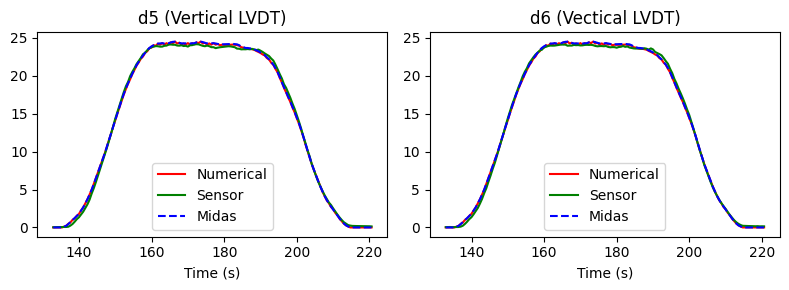

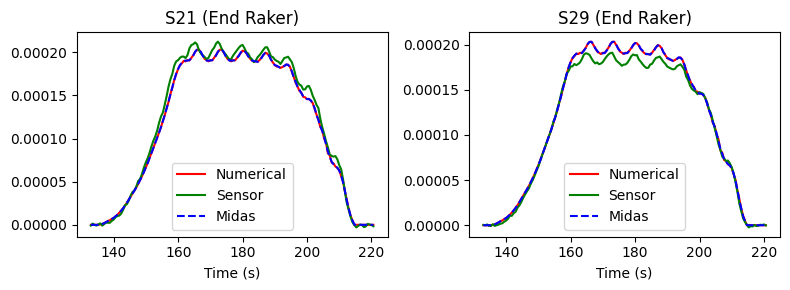

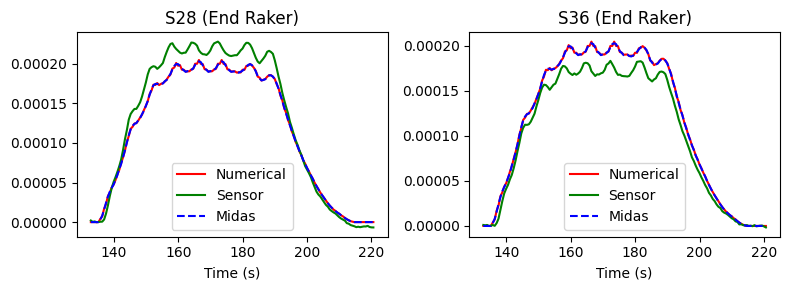

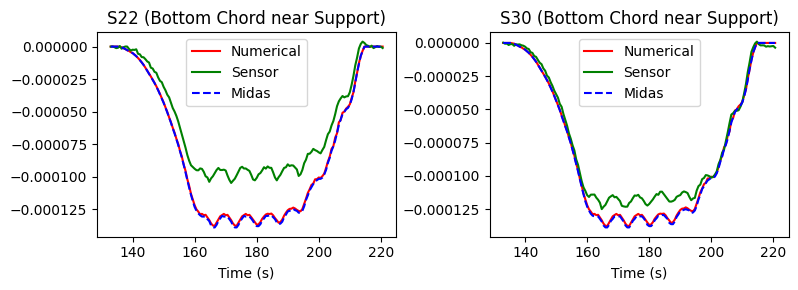

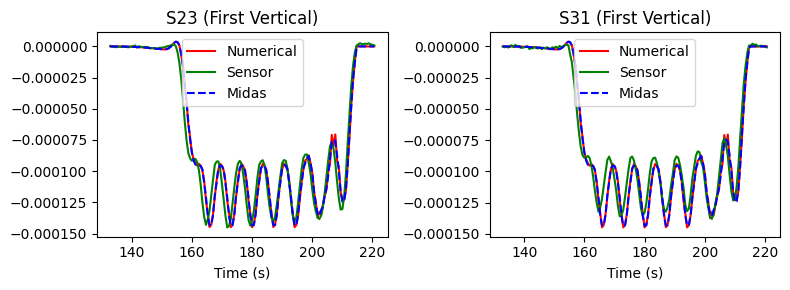

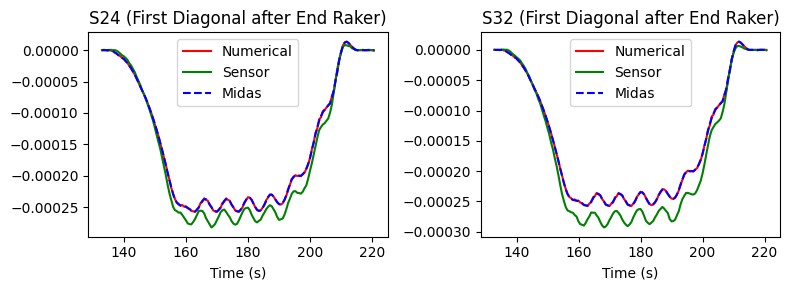

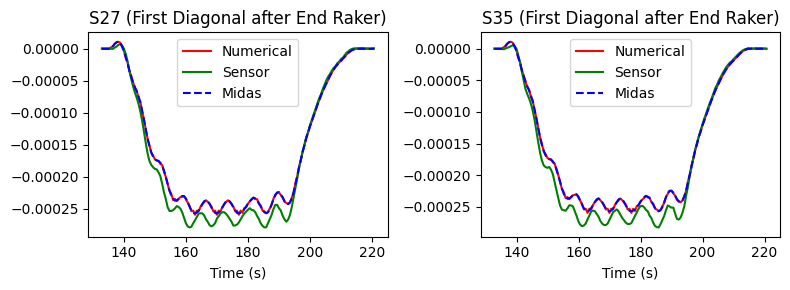

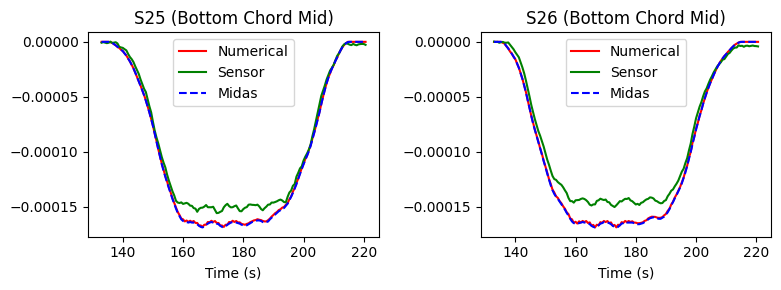

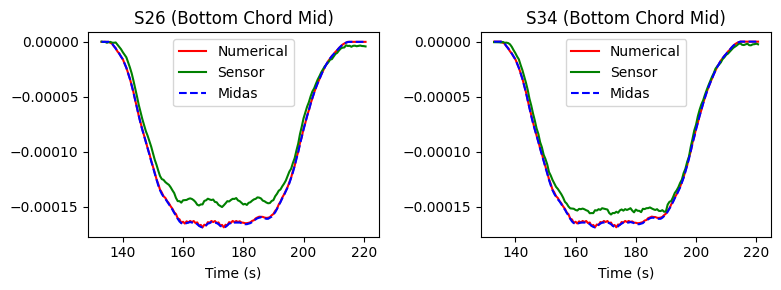

In [24]:
# Plotting the sets of graphs
from typing import Union
import matplotlib.pyplot as plt
import pandas as pd

def plotSets(_dfNumerical:Union[None,pd.DataFrame]=None,
             _dfSensor:Union[None,pd.DataFrame]=None,
             _dfMidas:Union[None,pd.DataFrame]=None,
             _dfNumericalAfterUpdating:Union[None, pd.DataFrame]=None,
             _dfMidasAfterUpdating:Union[None, pd.DataFrame]=None):
  _plotSets = [
    ('d5', 'd6'),
    ('S21', 'S29'), ('S28', 'S36'),
    ('S22', 'S30'),
    ('S23', 'S31'),
    ('S24', 'S32'), ('S27', 'S35'),
    ('S25', 'S26'), ('S26', 'S34'),
  ]
  _plotTitles = [
    ('d5 (Vertical LVDT)', 'd6 (Vectical LVDT)'),
    ('S21 (End Raker)', 'S29 (End Raker)'), ('S28 (End Raker)', 'S36 (End Raker)'),
    ('S22 (Bottom Chord near Support)', 'S30 (Bottom Chord near Support)'),
    ('S23 (First Vertical)', 'S31 (First Vertical)'),
    ('S24 (First Diagonal after End Raker)', 'S32 (First Diagonal after End Raker)'), ('S27 (First Diagonal after End Raker)', 'S35 (First Diagonal after End Raker)'),
    ('S25 (Bottom Chord Mid)', 'S26 (Bottom Chord Mid)'), ('S26 (Bottom Chord Mid)', 'S34 (Bottom Chord Mid)'),
  ]

  for __plotSet, __plotTitle in zip(_plotSets, _plotTitles):
    __fig, __axes = plt.subplots(1, len(__plotSet), figsize=(4*len(__plotSet),3), layout='tight')
    __filterRegex = r'^(' + r'|'.join(__plotSet) + r')'
    __legend = [] 
    if not _dfNumerical is None:
      _dfNumerical.filter(regex=__filterRegex).plot(subplots=True, ax=__axes, style="r-", title=__plotTitle)
      __legend.append("Numerical")
    if not _dfSensor is None:
      _dfSensor.filter(regex=__filterRegex).plot(subplots=True, ax=__axes, style="g-", title=__plotTitle)
      __legend.append("Sensor")
    if not _dfMidas is None:
      _dfMidas.filter(regex=__filterRegex).plot(subplots=True, ax=__axes, style="b--", title=__plotTitle)
      __legend.append("Midas")
    if not _dfNumericalAfterUpdating is None:
      _dfNumericalAfterUpdating.filter(regex=__filterRegex).plot(subplots=True, ax=__axes, style="y-", title=__plotTitle)
      __legend.append("Numerical Updated")
    if not _dfMidasAfterUpdating is None:
      _dfMidasAfterUpdating.filter(regex=__filterRegex).plot(subplots=True, ax=__axes, style="m--", title=__plotTitle)
      __legend.append("Midas Updated")
    for ___ax in __axes:
      ___ax.legend(__legend)
    plt.show()

plotSets(dfNumerical, dfSensor, dfMidas)

In [7]:
# Time Period from Sensor Data
timePeriodsSensor = [1/2.6734333281127327, 2/(5.322141232156581+5.417795990180595)]
print(timePeriodsSensor)

[0.3740508467087653, 0.18622082779407245]


In [8]:
# Time Period from Numerical Model
def getTimePeriodsFromNumericalModel() -> list[float]:
  _D, _V, _EffectiveMass, _MassParticipationFactor = DOFClass.eig(10)
  _timePeriod = 2*np.pi/_D**0.5
  _timePeriodTransverse1 = float(_timePeriod[np.argsort(_MassParticipationFactor[:,1].flatten())[-1]])
  _timePeriodVertical = float(_timePeriod[np.argsort(_MassParticipationFactor[:,2].flatten())[-1]])
  _timePeriodsNumerical = [_timePeriodTransverse1, _timePeriodVertical]
  return _timePeriodsNumerical

timePeriodsNumerical = getTimePeriodsFromNumericalModel()
print(timePeriodsNumerical)

[0.26870249397755197, 0.1853137362513847]


In [9]:
# Time Period from Midas Model
timePeriodsMidas = [1/2.6734333281127327, 2/(5.322141232156581+5.417795990180595)]
print(timePeriodsMidas)

[0.3740508467087653, 0.18622082779407245]


In [10]:
# Cost function for Live Load Results
import pandas as pd
import numpy as np

def costFunctionForLL(_dfNumerical:pd.DataFrame, _dfSensor:pd.DataFrame, _returnDataFrame=False):
  _ndNumerical = _dfNumerical.to_numpy()
  _ndSensor = _dfSensor.to_numpy()
  _ndResult = (_ndSensor - _ndNumerical).sum(axis=0)/_ndSensor.sum(axis=0)*100
  if _returnDataFrame:
    return pd.DataFrame([_ndResult], columns=_dfSensor.columns).sum(axis=0)
  return _ndResult

print(costFunctionForLL(dfNumerical, dfSensor, True))

d5 (mm)      -0.157056
d6 (mm)      -0.123278
S21 (m/m)     4.128314
S22 (m/m)   -34.755516
S23 (m/m)     0.901240
S24 (m/m)     7.568306
S25 (m/m)    -7.697129
S26 (m/m)   -11.816767
S27 (m/m)     7.135758
S28 (m/m)     9.434762
S29 (m/m)    -4.723567
S30 (m/m)    -9.353321
S31 (m/m)    -3.532552
S32 (m/m)    11.561714
S34 (m/m)    -6.243479
S35 (m/m)     7.696388
S36 (m/m)   -12.368571
dtype: float64


In [11]:
# Cost function for Time Period Results
def costFunctionForTimePeriod(_timePeriodNumerical:float, _timePeriodSensor:float) -> float:
  return (_timePeriodSensor - _timePeriodNumerical)/_timePeriodSensor*100
print(costFunctionForTimePeriod(timePeriodsNumerical[0], timePeriodsSensor[0]))
print(costFunctionForTimePeriod(timePeriodsNumerical[1], timePeriodsSensor[1]))

28.164179725340176
0.4871053111689733


In [12]:
# Structure Modification Function Generators
from typing import Union
from abc import ABC, abstractmethod
from Models import FixedBeam, Beam, Node

class StructureModifyFunctionLike(ABC):
  @abstractmethod
  def set(self):
    pass

  @abstractmethod
  def __call__(self):
    pass

  @abstractmethod
  def reset(self):
    pass

class NodeModifyFunctionLike(StructureModifyFunctionLike):
  def __init__(self, _nodes:list[Node], _DOFIndex:int):
    self.originalRestraint = []
    self.originalStiffness = []
    self.nodes = _nodes
    self.isSet = False
    self.DOFIndex = _DOFIndex
    for __node in self.nodes:
      self.originalRestraint.append(__node.restraint[self.DOFIndex])
      self.originalStiffness.append(np.diag(__node.Kg)[self.DOFIndex])
  
  def set(self):
    for __node in self.nodes:
      __nodeRestraint = __node.restraint.copy()
      __nodeRestraint[self.DOFIndex] = 0
      __node.addRestraint(__nodeRestraint)
    self.isSet = True

  def __call__(self, _Xi:float) -> None:
    if not self.isSet:
      raise Exception("Set the function before calling it")
    _Xi = float(_Xi)
    # _Xi = max(_Xi, 0.01)
    for __node in self.nodes:
      __nodeStiffness = np.diag(__node.Kg).copy()
      __nodeStiffness[self.DOFIndex] = _Xi*10_000_000
      __node.setStiffness(__nodeStiffness)

  def reset(self):
    for __node, __restraint, __stiffness in zip(self.nodes, self.originalRestraint, self.originalStiffness):
      __nodeRestraint = __node.restraint.copy()
      __nodeStiffness = np.diag(__node.Kg).copy()
      __nodeRestraint[self.DOFIndex] = __restraint
      __nodeStiffness[self.DOFIndex] = __stiffness
      __node.addRestraint(__nodeRestraint)
      __node.setStiffness(__nodeStiffness)
    self.isSet = False
  
class BeamEndStiffnessModifyFunctionLike(StructureModifyFunctionLike):
  def __init__(self, _beams:list[Beam], _DOFIndex:int):
    self.originalConstraint = []
    self.originalStiffnessFactor = []
    self.beams = _beams
    self.isSet = False
    self.DOFIndex = _DOFIndex
    for __beam in self.beams:
      self.originalConstraint.append((__beam.constraintsA[self.DOFIndex], __beam.constraintsB[self.DOFIndex]))
      self.originalStiffnessFactor.append((__beam.endStiffnessFactorA[self.DOFIndex], __beam.endStiffnessFactorB[self.DOFIndex]))

  def set(self):
    for __beam in self.beams:
      __beamConstraintsA, __beamConstraintsB = __beam.constraintsA.copy(), __beam.constraintsB.copy()
      __beamConstraintsA[self.DOFIndex] = __beamConstraintsB[self.DOFIndex] = 0
      __beam.setEndConstrains(__beamConstraintsA, __beamConstraintsB)
    self.isSet = True

  def __call__(self, _Xi:float) -> None:
    if not self.isSet:
      raise Exception("Set the function before calling it")
    _Xi = float(_Xi)
    _Xi = max(_Xi, 0.01)
    for __beam in self.beams:
      __beamEndStiffnessFactorA, __beamEndStiffnessFactorB = __beam.endStiffnessFactorA.copy(), __beam.endStiffnessFactorB.copy()
      __beamEndStiffnessFactorA[self.DOFIndex] = __beamEndStiffnessFactorB[self.DOFIndex] = _Xi
      __beam.setEndStiffnessFactor(__beamEndStiffnessFactorA, __beamEndStiffnessFactorB)

  def reset(self):
    for __beam, __constraint, __stiffnessFactor  in zip(self.beams, self.originalConstraint, self.originalStiffnessFactor):
      __beamConstraintsA, __beamConstraintsB = __beam.constraintsA.copy(), __beam.constraintsB.copy()
      __beamConstraintsA[self.DOFIndex], __beamConstraintsB[self.DOFIndex] = __constraint
      __beamEndStiffnessFactorA, __beamEndStiffnessFactorB = __beam.endStiffnessFactorA.copy(), __beam.endStiffnessFactorB.copy()
      __beamEndStiffnessFactorA[self.DOFIndex], __beamEndStiffnessFactorB[self.DOFIndex] = __stiffnessFactor
      __beam.setEndConstrains(__beamConstraintsA, __beamConstraintsB)
      __beam.setEndStiffnessFactor(__beamEndStiffnessFactorA, __beamEndStiffnessFactorB)
    self.isSet = False

class FixedBeamStiffnessFactorModifyFunctionLike(StructureModifyFunctionLike):
  def __init__(self, _beams:list[Union[Beam,FixedBeam]]):
    self.originalStiffnessFactor:list[float] = []
    self.fixedBeams:list[FixedBeam] = []
    self.isSet = False

    for __beam in _beams:
      if type(__beam) is FixedBeam:
        self.fixedBeams.append(__beam)
      elif type(__beam) is Beam:
        self.fixedBeams.extend(__beam.childBeams)    
    
    for ___fixedBeam in self.fixedBeams:
      self.originalStiffnessFactor.append(___fixedBeam.stiffnessFactor)

  def set(self):
    self.isSet = True

  def __call__(self, _Xi:float) -> None:
    if not self.isSet:
      raise Exception("Set the function before calling it")
    _Xi = float(_Xi)
    _Xi = min(max(_Xi, 0.8), 1.2)
    for __fixedBeam in self.fixedBeams:
      __fixedBeam.setStiffnessFactor(_Xi)

  def reset(self):
    for __fixedBeam, __stiffnessFactor  in zip(self.fixedBeams, self.originalStiffnessFactor):
      __fixedBeam.setStiffnessFactor(__stiffnessFactor)
    self.isSet = False

def generateNodeFxModifyFunction(_nodes:list[Node]) -> StructureModifyFunctionLike:
  return NodeModifyFunctionLike(_nodes, 0)

def generateNodeFyModifyFunction(_nodes:list[Node]) -> StructureModifyFunctionLike:
  return NodeModifyFunctionLike(_nodes, 1)

def generateNodeMyModifyFunction(_nodes:list[Node]) -> StructureModifyFunctionLike:
  return NodeModifyFunctionLike(_nodes, 4)

def generateBeamEndStiffnessFxModifyFunction(_beams:list[Beam]) -> StructureModifyFunctionLike:
  return BeamEndStiffnessModifyFunctionLike(_beams, 0)

def generateBeamEndStiffnessMyModifyFunction(_beams:list[Beam]) -> StructureModifyFunctionLike:
  return BeamEndStiffnessModifyFunctionLike(_beams, 4)

def generateFixedBeamStiffnessFactorModifyFunction(_beams:list[Union[FixedBeam,Beam]]) -> StructureModifyFunctionLike:
  return FixedBeamStiffnessFactorModifyFunctionLike(_beams)

def generateBeamMassFactorModifyFunction(_beams:list[Beam]) -> StructureModifyFunctionLike:
  def _returnFunction(__Xi:float) -> None:
    __Xi = float(__Xi)
    # __Xi = max(min(__Xi, -0.1), 0.1)
    for ___beam in _beams:
      ___beam.setAdditionalMassFactor(__Xi)

  def set() -> None:
    pass

  def reset() -> None:
    for ___beam in _beams:
      # Assuming that the additional mass is 0 initially
      ___beam.setAdditionalMassFactor(0)
  _returnFunction.set = set
  _returnFunction.reset = reset
  
  return _returnFunction

In [13]:
# Defining function for Sensitivity Analysis
import pandas as pd

def sensitivityAnalysis(_nameAndStructureModifyingFunctionsAndValues:list[tuple[str, StructureModifyFunctionLike, float]], _shouldPlot=False):
  _sensitivityResult = pd.DataFrame(index=list(dfNumerical.columns)+["TPTrans", "TPVert",])
  _sensitivityResult["Sensor"] = list(costFunctionForLL(dfNumerical, dfSensor)) + [
      costFunctionForTimePeriod(timePeriodsNumerical[0], timePeriodsSensor[0]),
      costFunctionForTimePeriod(timePeriodsNumerical[1], timePeriodsSensor[1]),
    ]
  for __name, __func, __Xi in _nameAndStructureModifyingFunctionsAndValues:
    __func.set()
    __func(__Xi)
    DOFClass.resetAllActionsAndReactions()
    DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()
    DOFClass.analyse()
    __dfNumericalAfterUpdating = getLLResultsFromNumericalModel(resultElements, dfSensor.columns)
    __dfNumericalAfterUpdating.index = dfSensor.index
    __timePeriodsNumericalAfterUpdating = getTimePeriodsFromNumericalModel()
    __costLL = list(costFunctionForLL(dfNumerical, __dfNumericalAfterUpdating))
    __costTimePeriod = [
      costFunctionForTimePeriod(timePeriodsNumerical[0], __timePeriodsNumericalAfterUpdating[0]),
      costFunctionForTimePeriod(timePeriodsNumerical[1], __timePeriodsNumericalAfterUpdating[1]),
    ]
    _sensitivityResult[__name] = __costLL + __costTimePeriod
    if _shouldPlot:
      plotSets(dfNumerical, dfSensor, __dfNumericalAfterUpdating)
    __func.reset()
  return _sensitivityResult.round(2)

In [14]:
# Sensitivity Analysis for Moment Releases

sensitivityAnalysis([
  # *((f"Bottom Chord{__i} My", generateBeamEndStiffnessMyModifyFunction([
  #   structure.truss1.bottomChordBeams[__i],
  #   structure.truss1.bottomChordBeams[__j],
  #   structure.truss2.bottomChordBeams[__i],
  #   structure.truss2.bottomChordBeams[__j],
  #   ]), 0.01) for __i, __j in [(0,-1), (1, -2)]),
  ("All Bottom Chords My", generateBeamEndStiffnessMyModifyFunction([
    *structure.truss1.bottomChordBeams,
    *structure.truss2.bottomChordBeams,
    ]), 0.01),
  # *((f"Top Chord{__i} My", generateBeamEndStiffnessMyModifyFunction([
  #   structure.truss1.topChordBeams[__i],
  #   structure.truss1.topChordBeams[__j],
  #   structure.truss2.topChordBeams[__i],
  #   structure.truss2.topChordBeams[__j],
  #   ]), 0.01) for __i, __j in [(0,-1), (1,-2)]),
  ("All Top Chords My", generateBeamEndStiffnessMyModifyFunction([
    *structure.truss1.topChordBeams,
    *structure.truss2.topChordBeams,
    ]), 0.01),
  # *((f"Diagonal{__i} My", generateBeamEndStiffnessMyModifyFunction([
  #   structure.truss1.diagonalBeams[__i],
  #   structure.truss1.diagonalBeams[__j],
  #   structure.truss2.diagonalBeams[__i],
  #   structure.truss2.diagonalBeams[__j],
  #   ]), 0.01) for __i, __j in [(0,-1), (1,-2), (2,-3), (3,-4)]),
  ("All Diagonals My", generateBeamEndStiffnessMyModifyFunction([
    *structure.truss1.diagonalBeams,
    *structure.truss2.diagonalBeams,
    ]), 0.01),
  # *((f"Vertical{__i} My", generateBeamEndStiffnessMyModifyFunction([
  #   structure.truss1.verticalBeams[__i],
  #   structure.truss1.verticalBeams[__j],
  #   structure.truss2.verticalBeams[__i],
  #   structure.truss2.verticalBeams[__j],
  #   ]), 0.01) for __i, __j in [(0,-1), (1,-2), (2,-3), (3,-4)]),
  ("All Verticals My", generateBeamEndStiffnessMyModifyFunction([
    *structure.truss1.verticalBeams,
    *structure.truss2.verticalBeams,
    ]), 0.01),
  ("All Cross Girders My", generateBeamEndStiffnessMyModifyFunction([
    *structure.cross_girders,
    *structure.sway_girders,
    *structure.portal_girders,
    ]), 0.01),
  ])

c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix

,Sensor,All Bottom Chords My,All Top Chords My,All Diagonals My,All Verticals My,All Cross Girders My
d5 (mm),-0.16,0.03,0.07,0.21,0.04,0.17
d6 (mm),-0.12,0.03,0.07,0.21,0.04,0.16
S21 (m/m),4.13,-0.05,-0.03,0.28,0.03,0.07
S22 (m/m),-34.76,0.08,-0.06,1.09,0.00,-0.08
S23 (m/m),0.90,0.10,0.17,1.93,-0.04,0.16
S24 (m/m),7.57,-0.17,0.47,0.44,0.12,-0.02
S25 (m/m),-7.70,0.22,0.11,0.27,0.02,0.59
S26 (m/m),-11.82,0.22,0.11,0.27,0.02,0.60
S27 (m/m),7.14,-0.17,0.47,0.44,0.12,-0.02
S28 (m/m),9.43,-0.05,-0.03,0.28,0.03,-0.05


In [15]:
# Sensitivity Analysis for Node Releases

sensitivityAnalysis([
  ("Roller Truss1 Fx", generateNodeFxModifyFunction([
    structure.truss1.node_by_name("L0"),
    ]), 10),
  ("Roller Truss2 Fx", generateNodeFxModifyFunction([
    structure.truss2.node_by_name("L0"),
    ]), 10),
  ("Both Truss Roller Fx", generateNodeFxModifyFunction([
    structure.truss1.node_by_name("L0"),
    structure.truss2.node_by_name("L0"),
    ]), 10),
  ("Transverse Roller Truss2 L0", generateNodeFyModifyFunction([
    structure.truss2.node_by_name("L0"),
    ]), 10),
  ("Transverse Roller Truss2 L8", generateNodeFyModifyFunction([
    structure.truss2.node_by_name("L8"),
    ]), 10),
  ("Pin Truss1 My", generateNodeMyModifyFunction([
    structure.truss1.node_by_name("L0"),
    ]), 10),
  ("Pin Truss2 My", generateNodeMyModifyFunction([
    structure.truss2.node_by_name("L0"),
    ]), 10),
  ("Roller Truss1 My", generateNodeMyModifyFunction([
    structure.truss1.node_by_name("L8"),
    ]), 10),
  ("Roller Truss2 My", generateNodeMyModifyFunction([
    structure.truss2.node_by_name("L8"),
    ]), 10),
  ])

c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix

,Sensor,Roller Truss1 Fx,Roller Truss2 Fx,Both Truss Roller Fx,Transverse Roller Truss2 L0,Transverse Roller Truss2 L8,Pin Truss1 My,Pin Truss2 My,Roller Truss1 My,Roller Truss2 My
d5 (mm),-0.16,-6.89,-4.50,-10.19,0.00,0.00,-0.30,-0.17,-0.27,-0.21
d6 (mm),-0.12,-4.50,-6.88,-10.18,0.00,0.00,-0.17,-0.30,-0.21,-0.27
S21 (m/m),4.13,2.70,-2.97,-0.09,-0.00,0.00,-1.18,-0.10,-0.16,-0.09
S22 (m/m),-34.76,-389.95,0.22,-214.75,0.04,0.00,-4.46,-0.09,-0.07,-0.19
S23 (m/m),0.90,2.27,-0.22,1.77,-0.02,0.00,-3.42,0.01,-0.01,-0.01
S24 (m/m),7.57,2.67,-3.85,-0.84,0.00,0.00,1.25,-0.18,-0.23,-0.12
S25 (m/m),-7.70,-31.29,-10.06,-39.57,-0.00,0.00,-0.45,-0.31,0.02,-0.43
S26 (m/m),-11.82,-26.35,-13.77,-39.53,-0.00,0.00,-0.18,-0.22,-0.17,-0.60
S27 (m/m),7.14,-2.09,1.05,-0.86,0.00,0.00,-0.25,-0.09,1.15,-0.07
S28 (m/m),9.43,-2.29,2.07,-0.11,0.00,-0.00,-0.20,-0.04,-1.27,-0.01


In [16]:
# Sensitivity Analysis for Beam Stiffness Variation

sensitivityAnalysis([
  ("Truss1 Beam Stiffness Factor", generateFixedBeamStiffnessFactorModifyFunction([
    *structure.truss1.beams,
    ]), 0.95),
  ("Truss2 Beam Stiffness Factor", generateFixedBeamStiffnessFactorModifyFunction([
    *structure.truss2.beams,
    ]), 0.95),
  ("All Truss Beam Stiffness Factor", generateFixedBeamStiffnessFactorModifyFunction([
    *structure.truss1.beams,
    *structure.truss2.beams,
    ]), 0.95),
  ("All Beam Stiffness Factor", generateFixedBeamStiffnessFactorModifyFunction([
    *structure.beams,
    ]), 0.95),
  ("Additional Mass Factor", generateBeamMassFactorModifyFunction([
    *structure.beams,
    ]), 0.05),
  ])

c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix

,Sensor,Truss1 Beam Stiffness Factor,Truss2 Beam Stiffness Factor,All Truss Beam Stiffness Factor,All Beam Stiffness Factor,Additional Mass Factor
d5 (mm),-0.16,3.36,1.26,4.59,5.00,-0.00
d6 (mm),-0.12,1.26,3.36,4.59,5.00,-0.00
S21 (m/m),4.13,4.65,0.36,4.99,5.00,-0.00
S22 (m/m),-34.76,3.96,0.04,4.00,5.00,-0.00
S23 (m/m),0.90,5.01,-0.12,4.90,5.00,0.00
S24 (m/m),7.57,4.08,0.97,5.03,5.00,-0.00
S25 (m/m),-7.70,1.93,1.88,3.81,5.00,-0.00
S26 (m/m),-11.82,1.88,1.93,3.81,5.00,-0.00
S27 (m/m),7.14,4.16,0.89,5.02,5.00,-0.00
S28 (m/m),9.43,4.73,0.28,5.00,5.00,-0.00


In [17]:
# Optimizing Function
from typing import Union
import numpy as np
import numpy.typing as npt
import pandas as pd
from Models import DOFClass, FixedBeam

def optimizingFunction(
    _X:npt.NDArray[np.float64],
    _structureModificationFunctions:list[StructureModifyFunctionLike],
    _LLResultsParameters:list[tuple[pd.DataFrame, list[Union[DOFClass, FixedBeam]], list[float]]],
    _timePeriodResultsList:list[int] = [],
    _shouldPrintInfo:bool=False,
    ):
  if _shouldPrintInfo:
    print(f"Optimized function called with {_X=}")
  DOFClass.resetAllActionsAndReactions()
  DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()
  for __func, __Xi  in zip(_structureModificationFunctions, _X):
    __func(__Xi)
  DOFClass.analyse()
  
  _returnValue = []
  for __parameter in _LLResultsParameters:
    __dfSensor = __parameter[0]
    __resultElements = __parameter[1]
    __resultElementFactors = __parameter[2]
    __dfNumericalRaw = getLLResultsFromNumericalModel(__resultElements, __dfSensor.columns)
    _returnValue.append(np.dot(costFunctionForLL(__dfNumericalRaw, __dfSensor), __resultElementFactors))
  
  if len(_timePeriodResultsList) != 0:
    __timePeriodsNumerical = getTimePeriodsFromNumericalModel()
    for ___index in _timePeriodResultsList:
      ___timePeriodNumerical = __timePeriodsNumerical[___index]
      ___timePeriodSensor = timePeriodsSensor[___index]
      _returnValue.append(costFunctionForTimePeriod(___timePeriodNumerical, ___timePeriodSensor))

  _returnValue = np.array(_returnValue)
  if _shouldPrintInfo:
    print(f"Optimized function returns {_returnValue=}")
  return _returnValue

In [18]:
# Updating Truss node stiffness, element Stiffness and Mass by finding roots
import pandas as pd
from scipy.optimize import root

def updateByFindingRoots1(_previousNameAndStructureModifyingFunctionAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = []) -> list[tuple[str, StructureModifyFunctionLike, float]]:
  _nameAndStructureModifyingFunctionsAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = [
    ("Roller1Fx", generateNodeFxModifyFunction([
      structure.truss1.node_by_name("L0"),
      ]), 2.768),
    ("Roller2Fx", generateNodeFxModifyFunction([
      structure.truss2.node_by_name("L0"),
      ]), 1.039),
    ("StiffnessFactorAllBeams", generateFixedBeamStiffnessFactorModifyFunction([
      *structure.beams,
      ]), 0.972),
    ("AdditionalMassFactor", generateBeamMassFactorModifyFunction([
      *structure.beams,
      ]), 0.01096),
  ]
  
  _name, _structureModificationFunctions, _initialX0 = zip(*_nameAndStructureModifyingFunctionsAndValues)

  _LLResultsParameters:list[tuple[pd.DataFrame, list[Union[DOFClass, FixedBeam]], list[float]]] = [
    (dfSensor.filter(regex='^S(22|25|26)'),
      [resultElements[__index] for __index in [22-19, 25-19, 26-19, ]],
      [1, 1, 1,  ]),
    (dfSensor.filter(regex='^S(30|34)'),
      [resultElements[__index] for __index in [30-19, 34-20, ]],
      [1, 1, ]),
    (dfSensor,
      resultElements,
      [1] * len(resultElements)),
  ]

  for __name, __func, __Xi in _previousNameAndStructureModifyingFunctionAndValues:
    __func.set()
    __func(__Xi)

  for __func in _structureModificationFunctions:
    __func.set()

  # optimizingFunction(_initialX0, _structureModificationFunctions, _LLResultsParameters, True)
  _optimizedResultObject = root(optimizingFunction, _initialX0, (_structureModificationFunctions, _LLResultsParameters, [1], True))
  print(_optimizedResultObject)

  for __func in _structureModificationFunctions:
    __func.reset()

  for __name, __func, __Xi in _previousNameAndStructureModifyingFunctionAndValues:
    __func.reset()

  _nextNameAndStructureModifyingFunctionAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = _previousNameAndStructureModifyingFunctionAndValues.copy()
  for __obj1, __Xi in zip(_nameAndStructureModifyingFunctionsAndValues, _optimizedResultObject.x):
    _nextNameAndStructureModifyingFunctionAndValues.append((__obj1[0], __obj1[1], __Xi))

  return _nextNameAndStructureModifyingFunctionAndValues

updatedNameAndStructureModifyingFunctionsAndValues1 = updateByFindingRoots1()

Optimized function called with _X=array([2.768  , 1.039  , 0.972  , 0.01096])


c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Optimized function returns _returnValue=array([-0.10978246, -0.08322589, -0.72517942, -0.02198454])
Optimized function called with _X=array([2.768  , 1.039  , 0.972  , 0.01096])
Optimized function returns _returnValue=array([-0.10978246, -0.08322589, -0.72517942, -0.02198454])
Optimized function called with _X=array([2.768  , 1.039  , 0.972  , 0.01096])
Optimized function returns _returnValue=array([-0.10978246, -0.08322589, -0.72517942, -0.02198454])
Optimized function called with _X=array([2.76800004, 1.039     , 0.972     , 0.01096   ])
Optimized function returns _returnValue=array([-0.10978168, -0.08322584, -0.72517855, -0.02198453])
Optimized function called with _X=array([2.768     , 1.03900002, 0.972     , 0.01096   ])
Optimized function returns _returnValue=array([-0.10978243, -0.08322565, -0.72517913, -0.02198454])
Optimized function called with _X=array([2.768     , 1.039     , 0.97200001, 0.01096   ])
Optimized function returns _returnValue=array([-0.10977879, -0.08322319, -

In [19]:
# Updating Truss Transverse Time Period
import pandas as pd
from scipy.optimize import root

def updateByFindingRoots2(_previousNameAndStructureModifyingFunctionAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = []) -> list[tuple[str, StructureModifyFunctionLike, float]]:
  _nameAndStructureModifyingFunctionsAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = [
    ("CrossGirderMy", generateBeamEndStiffnessMyModifyFunction([
      *structure.cross_girders,
      *structure.sway_girders,
      *structure.portal_girders,
      ]), 0.01),
  ]
  
  _name, _structureModificationFunctions, _initialX0 = zip(*_nameAndStructureModifyingFunctionsAndValues)

  _LLResultsParameters:list[tuple[pd.DataFrame, list[Union[DOFClass, FixedBeam]], list[float]]] = [
  ]

  for __name, __func, __Xi in _previousNameAndStructureModifyingFunctionAndValues:
    __func.set()
    __func(__Xi)

  for __func in _structureModificationFunctions:
    __func.set()

  # optimizingFunction(_initialX0, _structureModificationFunctions, _LLResultsParameters, True)
  _optimizedResultObject = root(optimizingFunction, _initialX0, (_structureModificationFunctions, _LLResultsParameters, [0], True))
  print(_optimizedResultObject)

  for __func in _structureModificationFunctions:
    __func.reset()

  for __name, __func, __Xi in _previousNameAndStructureModifyingFunctionAndValues:
    __func.reset()

  _nextNameAndStructureModifyingFunctionAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = _previousNameAndStructureModifyingFunctionAndValues.copy()
  for __obj1, __Xi in zip(_nameAndStructureModifyingFunctionsAndValues, _optimizedResultObject.x):
    _nextNameAndStructureModifyingFunctionAndValues.append((__obj1[0], __obj1[1], __Xi))

  return _nextNameAndStructureModifyingFunctionAndValues

updatedNameAndStructureModifyingFunctionsAndValues2 = updateByFindingRoots2(updatedNameAndStructureModifyingFunctionsAndValues1)

Optimized function called with _X=array([0.01])
Optimized function returns _returnValue=array([1.75543078])
Optimized function called with _X=array([0.01])
Optimized function returns _returnValue=array([1.75543078])
Optimized function called with _X=array([0.01])
Optimized function returns _returnValue=array([1.75543078])
Optimized function called with _X=array([0.01])
Optimized function returns _returnValue=array([1.75543091])
Optimized function called with _X=array([0.00802694])
Optimized function returns _returnValue=array([1.75543078])
Optimized function called with _X=array([0.01098653])
Optimized function returns _returnValue=array([2.60220607])
Optimized function called with _X=array([0.01])
Optimized function returns _returnValue=array([1.75543091])
Optimized function called with _X=array([0.00802694])
Optimized function returns _returnValue=array([1.75543078])
Optimized function called with _X=array([0.00901347])
Optimized function returns _returnValue=array([1.75543078])
Opti

In [20]:
# Final Updating by fmin
import pandas as pd
import numpy as np
from scipy.optimize import fmin

def updateByfmin(_nameAndStructureModifyingFunctionsAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = []) -> list[tuple[str, StructureModifyFunctionLike, float]]:
  _name, _structureModificationFunctions, _initialX0 = zip(*_nameAndStructureModifyingFunctionsAndValues)

  _LLResultsParameters:list[tuple[pd.DataFrame, list[Union[DOFClass, FixedBeam]], list[float]]] = [
    *[(dfSensor[[dfSensor.columns[__index]]],
      [resultElements[__index]],
      [1,]) for __index in range(len(resultElements))],
  ]

  for __func in _structureModificationFunctions:
    __func.set()

  def _optimizingFunctionForfmin(*args):
    __result = optimizingFunction(*args)
    return np.linalg.norm(__result)**2

  # optimizingFunction(_initialX0, _structureModificationFunctions, _LLResultsParameters, True)
  _optimizedResultObject = fmin(_optimizingFunctionForfmin, _initialX0, (_structureModificationFunctions, _LLResultsParameters, [1], True), xtol=0.01)
  print(_optimizedResultObject)
  
  for __func in _structureModificationFunctions:
    __func.reset()

  _updatedNameAndStructureModifyingFunctionAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = []
  for __obj1, __Xi in zip(_nameAndStructureModifyingFunctionsAndValues, _optimizedResultObject):
    _updatedNameAndStructureModifyingFunctionAndValues.append((__obj1[0], __obj1[1], __Xi))

  return _updatedNameAndStructureModifyingFunctionAndValues

updatedNameAndStructureModifyingFunctionsAndValuesFinal = updateByfmin(updatedNameAndStructureModifyingFunctionsAndValues2)

Optimized function called with _X=array([2.76799437, 1.03917557, 0.97243261, 0.01095565, 0.00704041])


c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Optimized function returns _returnValue=array([  0.17629951,  -0.5706336 ,   1.03040586,   3.99923922,
        -2.72559978,   4.83886333,   0.45116651,  -4.19686752,
         4.95237539,   7.2741724 ,  -7.22658259,   0.86132559,
        -7.01348306,   9.65637006,  -1.58827734,   5.14663051,
       -16.00275451,  -0.07719584])
Optimized function called with _X=array([2.90639409, 1.03917557, 0.97243261, 0.01095565, 0.00704041])
Optimized function returns _returnValue=array([  0.29210697,  -0.51183054,   1.00661377,   5.81462428,
        -2.75067167,   4.81972519,   0.89223185,  -3.79910232,
         4.97296641,   7.29904987,  -7.19850374,   0.79152746,
        -7.01873183,   9.68799299,  -1.39902929,   5.1402419 ,
       -16.03162197,  -0.03598713])
Optimized function called with _X=array([2.76799437, 1.09113434, 0.97243261, 0.01095565, 0.00704041])
Optimized function returns _returnValue=array([  0.20040117,  -0.52060189,   1.0419834 ,   3.93465403,
        -2.72784379,   4.85369088,   

In [21]:
# Print Final Results after updating
from Models import DOFClass

def printUpdatedResultsAndReturnUpdatedDf(_nameAndStructureModifyingFunctionsAndValues:list[tuple[str, StructureModifyFunctionLike, float]] = []) -> None:
  _names, _structureModificationFunctions, _X0s = zip(*_nameAndStructureModifyingFunctionsAndValues)
  print(f"Optimized value for Truss in plane stiffness paramter(s):-")
  for __name, __X0 in zip(_names, _X0s):
    print(f"{__name} : {__X0:.4f}")

  for __func, __X0 in zip(_structureModificationFunctions, _X0s):
    __func.set()
    __func(__X0)

  DOFClass.resetAllActionsAndReactions()
  DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()
  DOFClass.analyse()  
  
  _dfNumericalAfterUpdating = getLLResultsFromNumericalModel(resultElements, dfSensor.columns)
  _dfNumericalAfterUpdating.index = dfSensor.index
  global timePeriodsNumericalAfterUpdating
  timePeriodsNumericalAfterUpdating = getTimePeriodsFromNumericalModel()
  
  for __func in _structureModificationFunctions:
    __func.reset()
  
  print("Final Time Period After Updating :-")
  print("Time Period Mode 1:")
  print(f"\tSensor = {timePeriodsSensor[0]:.3f} secs ")
  print(f"\tNumerical Before Updating = {timePeriodsNumerical[0]:.3f} secs ")
  print(f"\tNumerical After Updating = {timePeriodsNumericalAfterUpdating[0]:.3f} secs ")
  print("Time Period Mode 2:")
  print(f"\tSensor = {timePeriodsSensor[1]:.3f} secs ")
  print(f"\tNumerical Before Updating = {timePeriodsNumerical[1]:.3f} secs ")
  print(f"\tNumerical After Updating = {timePeriodsNumericalAfterUpdating[1]:.3f} secs ")
  print("")
  print("Plotting the LL Results")

  _costLL = list(costFunctionForLL(_dfNumericalAfterUpdating, dfSensor))
  _costTimePeriod = [
    costFunctionForTimePeriod(timePeriodsNumericalAfterUpdating[0], timePeriodsSensor[0]),
    costFunctionForTimePeriod(timePeriodsNumericalAfterUpdating[1], timePeriodsSensor[1]),
  ]

  _finalCost = pd.DataFrame(index=list(dfSensor.columns)+["TPTrans (secs)", "TPVert (secs)",])
  _finalCost["Percentage Error"] = _costLL + _costTimePeriod  
  print("Final Error between Updated Results and the Parameters from sensors")
  print(_finalCost.round(2))
  return _dfNumericalAfterUpdating

dfNumericalAfterUpdation = printUpdatedResultsAndReturnUpdatedDf(updatedNameAndStructureModifyingFunctionsAndValuesFinal)

Optimized value for Truss in plane stiffness paramter(s):-
Roller1Fx : 2.4627
Roller2Fx : 0.9746
StiffnessFactorAllBeams : 0.9813
AdditionalMassFactor : 0.0123
CrossGirderMy : 0.0078
Final Time Period After Updating :-
Time Period Mode 1:
	Sensor = 0.374 secs 
	Numerical Before Updating = 0.269 secs 
	Numerical After Updating = 0.367 secs 
Time Period Mode 2:
	Sensor = 0.186 secs 
	Numerical Before Updating = 0.185 secs 
	Numerical After Updating = 0.186 secs 

Plotting the LL Results
Final Error between Updated Results and the Parameters from sensors
                Percentage Error
d5 (mm)                     0.76
d6 (mm)                     0.12
S21 (m/m)                   1.96
S22 (m/m)                   0.59
S23 (m/m)                  -1.74
S24 (m/m)                   5.72
S25 (m/m)                   0.21
S26 (m/m)                  -4.33
S27 (m/m)                   5.76
S28 (m/m)                   8.06
S29 (m/m)                  -6.31
S30 (m/m)                   1.00
S31 (m/m)    

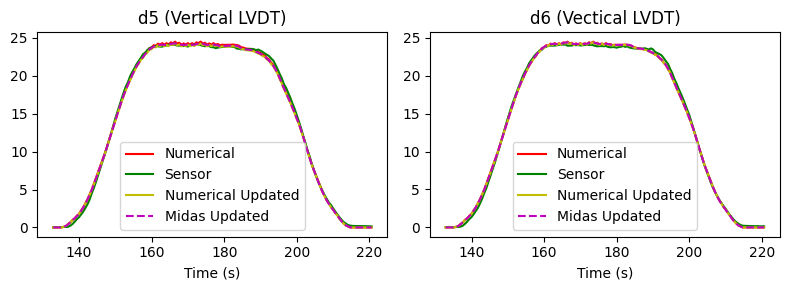

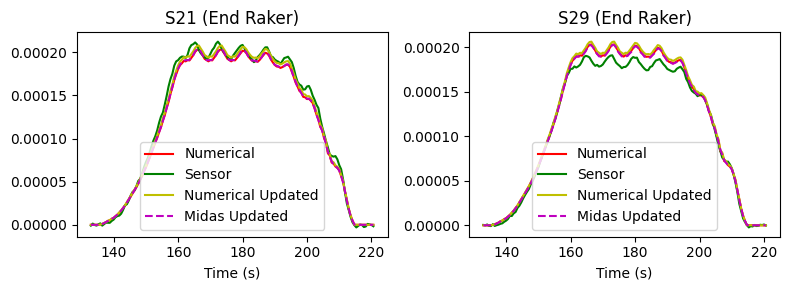

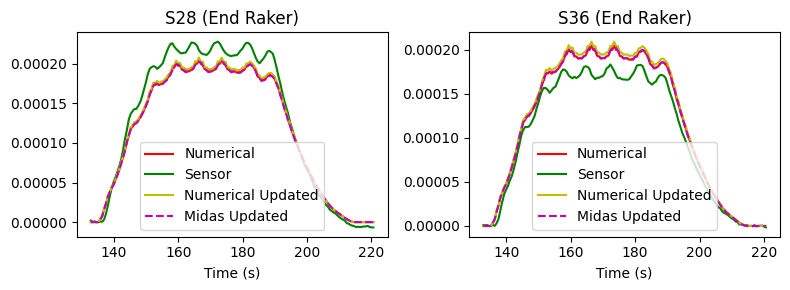

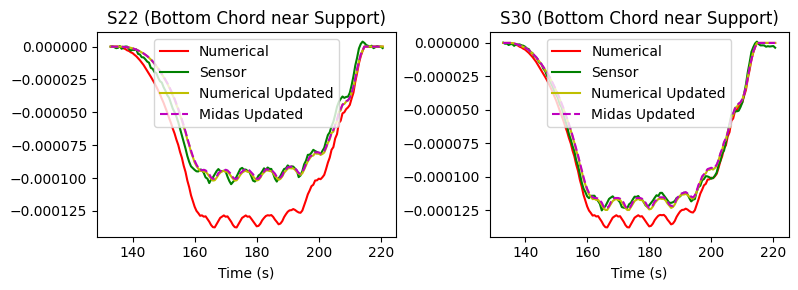

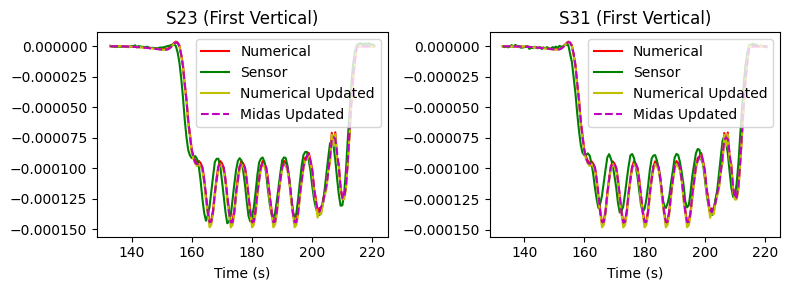

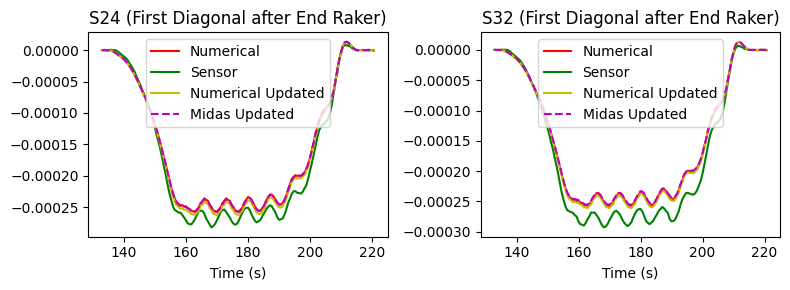

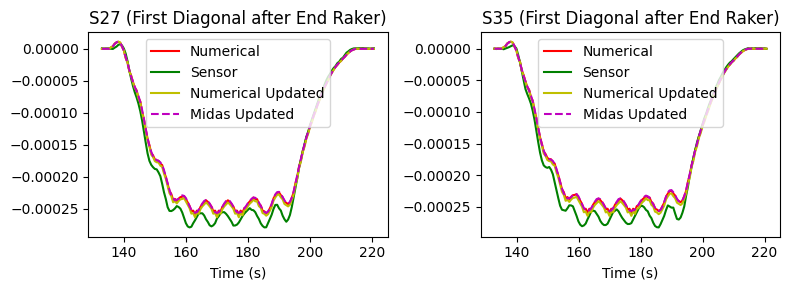

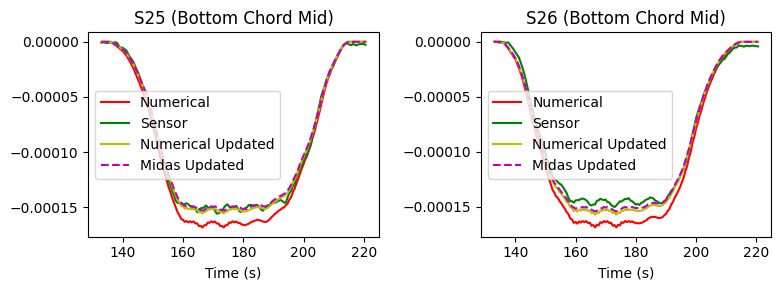

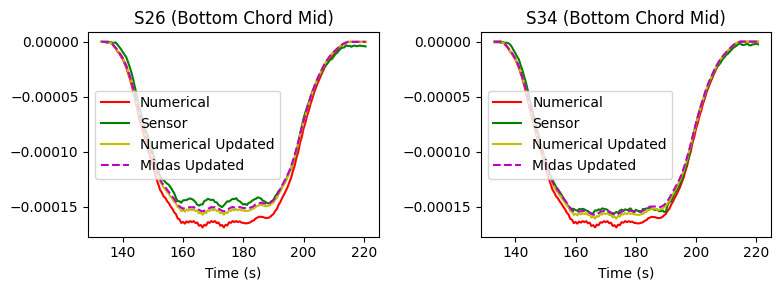

In [25]:
# Extracting Results from Midas and Plotting final result after updation
def getResultsFromMidasAndPlotResults() -> None:
  _dfMidasRawAfterUpdation = getLLDataFromMidasOutput(
    "Midas/Beam Stress_AfterUpdation_150LCs.xls",
    "Midas/Displacements(Global)_AfterUpdation_150LCs.xls",
    {   
        298: 'S21 (m/m)',
        1  : 'S22 (m/m)',
        354: 'S23 (m/m)',
        324: 'S24 (m/m)',
        5  : 'S25 (m/m)',
        6  : 'S26 (m/m)',
        320: 'S27 (m/m)',
        312: 'S28 (m/m)',
        302: 'S29 (m/m)',
        31 : 'S30 (m/m)',
        356: 'S31 (m/m)',
        327: 'S32 (m/m)',
        34 : 'S33 (m/m)',
        35 : 'S34 (m/m)',
        323: 'S35 (m/m)',
        313: 'S36 (m/m)',
        },
    {
        8: 'd5 (mm)',
        23: 'd6 (mm)',
        },
    _filterStrainRegex=r'^(?!(S33|S37|S38|S39|S40))', _filterDispRegex=r'^(?!(d7))',
    _shouldPlot=False,
    )
  _dfMidasAfterUpdation = _dfMidasRawAfterUpdation.copy()
  _dfMidasAfterUpdation.index = dfSensor.index
  
  plotSets(dfNumerical, dfSensor, None, dfNumericalAfterUpdation, _dfMidasAfterUpdation)

getResultsFromMidasAndPlotResults()

In [26]:
# TEMP

print(structure.cross_girders[0].childBeams[0].section.Area * structure.cross_girders[0].childBeams[0].section.E*0.01130623/1000)
print([f"{1/_:.2f}" for _ in timePeriodsSensor])
print([f"{1/_:.2f}" for _ in timePeriodsNumerical])
print([f"{1/_:.2f}" for _ in timePeriodsNumericalAfterUpdating])

57322.5861
['2.67', '5.37']
['3.72', '5.40']
['2.73', '5.38']
